### Mariana Sanchez y Laura Ortiz

# Parte 1

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.6 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import os
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import tensorflow_datasets as tfds

In [ ]:
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE = 20
HEIGHT = 224
WIDTH = 224
DEPTH = 3

In [ ]:
df,info = tfds.load('cassava',with_info=True,as_supervised=True)

In [ ]:
train_ds = df['train']
validation_ds = df['validation']
test_ds = df['test']

Como el conjunto de datos de Cassava consiste en imágenes de hojas de plantas de Cassava que representan cinco condiciones diferentes: saludable y cuatro enfermedades distintas (CMD, CBB, CGM y CBSD). Al ser un problema de clasificación multiclase, vamos a representar las etiquetas de manera que cada muestra pueda pertenecer a una de varias clases diferentes.

La codificación one-hot nos puede ayudar a tener una representación equilibrada de las clases y permitir al modelo aprender de manera más equitativa de todas las clases. Además, las etiquetas estaran en un formato adecuado para ser utilizadas con funciones de pérdida específicas para la clasificación multiclase, como CategoricalCrossentropy. Estas funciones de pérdida esperan que las etiquetas estén codificadas en one-hot encoding para calcular la pérdida correctamente.

In [ ]:
train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, (HEIGHT, WIDTH)), tf.one_hot(label, depth=5)))
validation_ds = validation_ds.map(lambda image, label: (tf.image.resize(image, (HEIGHT, WIDTH)), tf.one_hot(label, depth=5)))
test_ds = test_ds.map(lambda image, label: (tf.image.resize(image, (HEIGHT, WIDTH)), tf.one_hot(label, depth=5)))

train_ds = train_ds.batch(BATCH_SIZE)
validation_ds = validation_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
modelo_naive = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1. / 255, input_shape=(HEIGHT, WIDTH, DEPTH)),
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(factor=0.25),
    tf.keras.layers.RandomZoom((0.2, 0.5), (0.2, 0.5)),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
modelo_naive.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
                     metrics=["accuracy"])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True)]

history = modelo_naive.fit(train_ds, validation_data=validation_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
177/177 [==============================] - 34s 143ms/step - loss: 1.4104 - accuracy: 0.4556 - val_loss: 1.2773 - val_accuracy: 0.4754
Epoch 2/100
177/177 [==============================] - 24s 133ms/step - loss: 1.2910 - accuracy: 0.5104 - val_loss: 1.2457 - val_accuracy: 0.4981
Epoch 3/100
177/177 [==============================] - 24s 133ms/step - loss: 1.2130 - accuracy: 0.5636 - val_loss: 1.1213 - val_accuracy: 0.5834
Epoch 4/100
177/177 [==============================] - 25s 139ms/step - loss: 1.1691 - accuracy: 0.5826 - val_loss: 1.1313 - val_accuracy: 0.5823
Epoch 5/100
177/177 [==============================] - 23s 131ms/step - loss: 1.1235 - accuracy: 0.5964 - val_loss: 1.1330 - val_accuracy: 0.5834
Epoch 6/100
177/177 [==============================] - 23s 131ms/step - loss: 1.0917 - accuracy: 0.6137 - val_loss: 1.1573 - val_accuracy: 0.5924
Epoch 7/100
177/177 [==============================] - 24s 135ms/step - loss: 1.0659 - accuracy: 0.6139 - val_loss: 1.1099 -

In [ ]:
modelo_naive.save("cassava/modelo_naive")

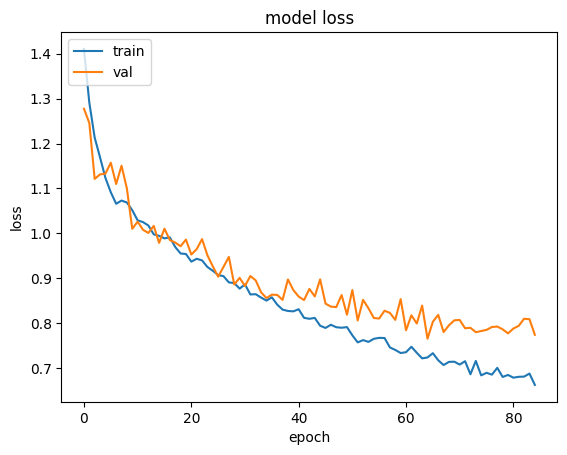

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()